In [2]:
#Use the conda env machine learning to work things
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import scipy.sparse as sparse
import re
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


First we read in the tabular data containing my pre-pared table of motif frequencies.

In [3]:
motif_df=pd.read_csv('Insulator_motif_dictionary_ext.csv')
motif_df.head()

,Unnamed: 0,CAGGG,AGGGT,GGGTT,GGTTG,GTTGC,TTGCC,TGCCC,GCCCA,CCCAG,...,TTAGN,TAGNN,AGNNN,GNNNN,GGCTN,GCTNN,CTNNN,NNNGG,NNGGC,NGGCC
0,0,14,12,10,4,6,9,12,8,19,...,0,0,0,0,0,0,0,0,0,0
1,1,33,9,5,2,2,5,28,19,44,...,0,0,0,0,0,0,0,0,0,0
2,2,23,6,6,5,4,7,10,13,27,...,0,0,0,0,0,0,0,0,0,0
3,3,7,5,7,7,14,15,11,9,12,...,0,0,0,0,0,0,0,0,0,0
4,4,11,4,8,7,11,9,15,13,27,...,0,0,0,0,0,0,0,0,0,0


Next we format it to include indices (1-Length of each dataset) and introduce scores; Insulator or not as 1 and 0

In [4]:
random_sequences = pd.read_csv('1000_8kb_random_samples_upper.tab',sep='\t',names=['Region','Sequence'])
insulator_sequences = pd.read_csv('insulator_library.tab',sep='\t',names=['Region','Sequence'])
combined_sequences=insulator_sequences.append(random_sequences)
X_full_data=motif_df
X_full_data.index = range(len(X_full_data))

X_full_data_indexed = X_full_data.iloc[:, 1::]

ins=[1]*len(insulator_sequences)
data=pd.DataFrame(ins)
rando=[0]*len(random_sequences)
scores=data.append(rando)

y_full_data = np.ravel(scores)
X_full_data_indexed.head()

,CAGGG,AGGGT,GGGTT,GGTTG,GTTGC,TTGCC,TGCCC,GCCCA,CCCAG,CCAGT,...,TTAGN,TAGNN,AGNNN,GNNNN,GGCTN,GCTNN,CTNNN,NNNGG,NNGGC,NGGCC
0,14,12,10,4,6,9,12,8,19,12,...,0,0,0,0,0,0,0,0,0,0
1,33,9,5,2,2,5,28,19,44,6,...,0,0,0,0,0,0,0,0,0,0
2,23,6,6,5,4,7,10,13,27,10,...,0,0,0,0,0,0,0,0,0,0
3,7,5,7,7,14,15,11,9,12,7,...,0,0,0,0,0,0,0,0,0,0
4,11,4,8,7,11,9,15,13,27,12,...,0,0,0,0,0,0,0,0,0,0


Perform train test splitting on a copied form of the dataset (copying means I can easily manipulate the dataset and re-run with the smame classifier
                                                             )

In [5]:
X_full=X_full_data_indexed.copy()
y_full=y_full_data.copy()
X_train, X_test,y_train,y_test = train_test_split(X_full, y_full, random_state = 1)


[[2353   50]
 [ 522  193]]


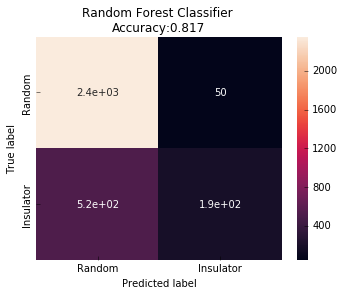

In [6]:
clf=RandomForestClassifier(n_estimators=100,max_depth=20,random_state=0)
clf.fit(X_train, y_train)
importances=pd.DataFrame(clf.feature_importances_)
predictions=pd.DataFrame(clf.predict(X_test))

y_pred=clf.predict(X_test)

from sklearn.metrics import confusion_matrix
%matplotlib inline
import seaborn as sns
cm=confusion_matrix(y_test,y_pred)
print(cm)
cm_df = pd.DataFrame(cm,
                     index = ['Random','Insulator'], 
                     columns = ['Random','Insulator'])

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Random Forest Classifier \nAccuracy:{0:.3f}'.format(accuracy_score(y_test, y_pred)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Lets have a look at the partial dependence plots for this baby

In [10]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(clf, random_state=1).fit(X_test, y_test)

In [11]:
eli5.show_weights(clf, feature_names = X_test.columns.tolist())

Weight,Feature
0.0081 ± 0.0404,CGCGG
0.0080 ± 0.0385,GCGGC
0.0080 ± 0.0436,CCGCG
0.0072 ± 0.0346,GCGCG
0.0068 ± 0.0378,CGGCG
0.0059 ± 0.0334,CGCGC
0.0056 ± 0.0316,GCGGG
0.0046 ± 0.0227,CCCGC
0.0043 ± 0.0233,CGCCG
0.0042 ± 0.0228,AGCGC


Re-running with the removal of any rows with >2500 NNNNN's

In [35]:
y_full_dataframe=pd.DataFrame(y_full_data)
y_full_dataframe
X_NNNNN_removed=X_full_data_indexed.loc[X_full_data_indexed['NNNNN']<=2500]
y_NNNNN_removed=y_full_dataframe.loc[X_full_data_indexed['NNNNN']<=2500]
y_NNNNN_removed=np.ravel(y_NNNNN_removed)



In [36]:
X_full=X_NNNNN_removed.copy()
y_full=y_NNNNN_removed.copy()

X_train, X_test,y_train,y_test = train_test_split(X_full, y_full, random_state = 1)
y_test

array([1, 0, 0, ..., 0, 0, 0], dtype=int64)

[[2170   46]
 [ 544  166]]


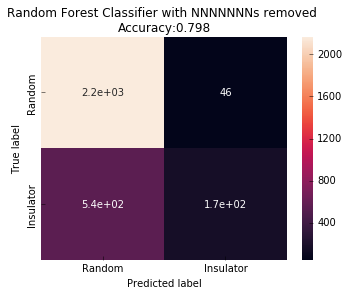

In [38]:
clf=RandomForestClassifier(n_estimators=200,max_depth=10,random_state=0)
clf.fit(X_train, y_train)
importances=pd.DataFrame(clf.feature_importances_)
predictions=pd.DataFrame(clf.predict(X_test))

y_pred=clf.predict(X_test)

from sklearn.metrics import confusion_matrix
%matplotlib inline
import seaborn as sns
cm=confusion_matrix(y_test,y_pred)
print(cm)
cm_df = pd.DataFrame(cm,
                     index = ['Random','Insulator'], 
                     columns = ['Random','Insulator'])

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Random Forest Classifier with NNNNNNNs removed \nAccuracy:{0:.3f}'.format(accuracy_score(y_test, y_pred)))
plt.ylabel('True label')
plt.xlabel('Predicted label')


I was suspcious that the differences I see might be purely a product of GC content- does shuffling predicted insulators to remove their structure have any effect?

In [8]:
y_full_data = np.ravel(scores)

In [9]:
y_full_data

array([1, 1, 1, ..., 0, 0, 0], dtype=int64)

In [1]:
import os

In [4]:
os.chdir('M:\"Machine Learning\"')

OSError: [WinError 123] The filename, directory name, or volume label syntax is incorrect: 'M:"Machine Learning"'